To have a clear idea of the best locations where the e-trike should operate it is important to identify the areas of the city with the largest affluence of passengers. At the moment, our smallest granularity unit area is the neighborhoods defined in section 3.2. To have a better understanding of the specific location of the hotspots around the city, it will be ideal to have a finer division of our dataset. To achieve that goal, we will implement two different clustering methods

# 1. Data preparation

## 1.1 Import Libraries 

In [2]:
library(data.table, quietly = TRUE, warn.conflicts = FALSE) # for fast data processing
library(dplyr, quietly = TRUE, warn.conflicts = FALSE) # data manipulation
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE) #data visualization
library(ggmap, quietly = TRUE, warn.conflicts = FALSE)
library(lubridate, quietly = TRUE, warn.conflicts = FALSE)
library(chron, quietly = TRUE, warn.conflicts = FALSE) #handling of dates
library(sp, quietly = TRUE, warn.conflicts = FALSE) #convert coord systems
library(RColorBrewer, quietly = TRUE, warn.conflicts = FALSE)

## 1.2 Helper functions

In [3]:
library(grid)
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)), ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,layout.pos.col = matchidx$col))
    }
  }
}

## 1.3 Import data

In [2]:
data <- fread('c:/datasets/NYCtaxi_cleaned_data.csv', sep=",", stringsAsFactors=F)

data <- data  %>% 
  mutate_at("pickup_county", funs(as.factor)) %>% 
  mutate_at("dropoff_county", funs(as.factor)) %>% 
  filter(pickup_county == "New York" & dropoff_county=="New York") %>%
  mutate_at("dataset", funs(as.factor)) %>% 
  mutate_at("holiday", funs(as.factor)) %>% 
  mutate(date         = date(date), 
         weekday      = lubridate::wday(date, label=TRUE),
         weekend      = is.weekend(date),
         month        = month(date, label = TRUE, abbr = FALSE))


Read 1815361 rows and 25 (of 25) columns from 0.324 GB file in 00:00:13


In [282]:
## RUN THIS CELL TO FILTER ROWS FOR TESTING PURPOSES
data <- sample_n(data, 50000)

## 1.2 Setup Cartesian and mercator coordinate systems

In [5]:
coords <- data %>%
    dplyr::select(dropoff_longitude,dropoff_latitude,hour,weekday) %>%
    rename(lon = dropoff_longitude, lat=dropoff_latitude)

# converts the coordinates to a SpatialPointsDataframe object
coordinates(coords) <- c("lon", "lat")

# Define the projection system and datum
proj4string(coords) <- CRS("+proj=longlat +datum=WGS84")  

# Create a SpatialPointsDataframe based on UTM coordinate system
res <- spTransform(coords, CRS("+proj=utm +zone=18 ellps=WGS84"))

grid<- data.frame(lon=coords$lon, lat=coords$lat,lonUtm = res$lon, latUtm=res$lat,hour=res$hour, weekday = res$weekday)
kmean<- data.frame(lon=coords$lon, lat=coords$lat, lonUtm = res$lon, latUtm=res$lat, hour=res$hour, weekday = res$weekday)


## 1.3 Grid Pattern clustering
Grid clustering consists in grouping the coordinates in identical blocks of 500 x 500 meters. This type of clustering, albeit its simplicity, allow us to have a quick and uniform division of Manhattan.

Given that the geographical coordinate system is in the latitude/longitude format, and we aim to make sectors based on meters we will convert our coordinates to the Universal Transverse Mercator (UTM) coordinate system. The meter-based GIS system will allow us to deal directly with distances and will eliminate projections bias created by the non-metric nature of the latitude/longitude coordinates.


Map from URL : http://tile.stamen.com/toner-lite/12/1205/1537.png
Map from URL : http://tile.stamen.com/toner-lite/12/1206/1537.png
Map from URL : http://tile.stamen.com/toner-lite/12/1207/1537.png
Map from URL : http://tile.stamen.com/toner-lite/12/1205/1538.png
Map from URL : http://tile.stamen.com/toner-lite/12/1206/1538.png
Map from URL : http://tile.stamen.com/toner-lite/12/1207/1538.png
Map from URL : http://tile.stamen.com/toner-lite/12/1205/1539.png
Map from URL : http://tile.stamen.com/toner-lite/12/1206/1539.png
Map from URL : http://tile.stamen.com/toner-lite/12/1207/1539.png
Map from URL : http://tile.stamen.com/toner-lite/12/1205/1540.png
Map from URL : http://tile.stamen.com/toner-lite/12/1206/1540.png
Map from URL : http://tile.stamen.com/toner-lite/12/1207/1540.png


[1] 202

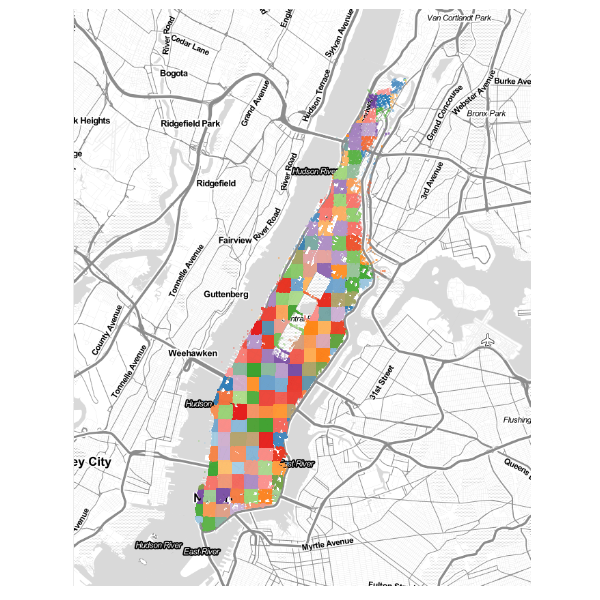

In [6]:
box <- c(left = -74.08, bottom = 40.68, right = -73.85, top = 40.9)
map <- get_stamenmap(box, zoom = 12, maptype = "toner-lite")

grid <- grid %>%  
     mutate(lonUtm400 = lonUtm %/% 600, latUtm400 = latUtm %/% 600)%>%   
     group_by(lonUtm400, latUtm400) %>% 
     mutate(lon400 = mean(lon), lat400 = mean(lat),count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

data <- cbind(data,grid[c("lon400","lat400")])

options(repr.plot.width=5, repr.plot.height=5)
hm_palette <- colorRampPalette(rev(brewer.pal(10, 'Paired')), space='Lab')  

data$sector <- paste("S",abs(data$lon400-data$lat400),sep="") 
data <-  subset( data, select = -c(lon400,lat400))   

length(unique(data$sector))


ggmap(map) + 
    geom_point(aes(x = lon, y = lat, color= as.factor(count)), data = grid, alpha = .2, size = .1) +
    scale_color_manual(values=sample(hm_palette(380))) +
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) 

In [69]:
data$sector <- paste("S",abs(data$lon400-data$lat400),sep="") 
data <-  subset( data, select = -c(lon400,lat400))   

length(unique(data$sector))


[1] 202

## 1.4 kmeans clustering

Alternatively, we will also implement K-means in our dataset. Rather than defining clusters arbitrarily as is the case of grid clustering, k-means allows us to group or information organically.
The k-means algorithm on R tries to minimize the within cluster sum of squares (withinss) of the data points inside our cluster. This metric is a standard for cluster forming and provide satisfactory results in the forming of clusters. However, in order to have a better understanding of the real size of our clusters in meters, we will implement a new metric that measures the average distance of all the data points to the center of the cluster. The average distance to the cluster center (ADCC) 

### Estimate best number of cluster

In [145]:
K_means <- sample_n(kmean, 50000)

dist = vector()

for (i in 1:200)  {  
   km1 = kmeans(K_means[,c("lonUtm","latUtm")],i, nstart=10) 
   K_means$cluster <-km1$cluster
      sum=0
    for (j in 1:i){  
        temp <- K_meansn  %>% filter(cluster == j)
        sum <- sum + mean(((temp$lonUtm - km1$centers[j,1])^2 + (temp$latUtm - km1$centers[j,2])^2)^0.5)
    }
    
    dist <- c(dist,round(sum/i,2))
}

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-T

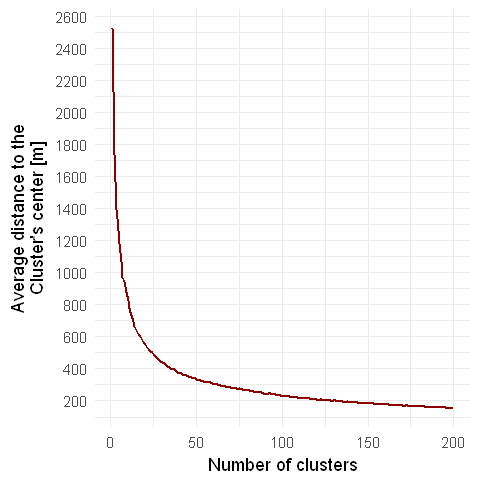

In [162]:
options(repr.plot.width=4, repr.plot.height=4) #Graph sizing in jupyter,for rstudio is not required  

        ggplot(data=data.frame(dist = dist, noClusters = seq(1,200,1)), aes(x=noClusters, y=dist)) +
        geom_line()+ labs(x = paste("Number of clusters"), y = "Average distance to the\nCluster's center [m]") +
        scale_y_continuous(breaks = seq(0,2600,200)) +
        geom_line(size=0.75,color="darkred") +
        theme_minimal() 

In [8]:
nclusters <- 100

# perform k-means
# attempts multiple initial configurations and reports on the best one
km1 = kmeans(kmean[,c("lonUtm","latUtm")],nclusters, nstart=10) 

#add the cluster to the dataframe
kmean$cluster <-km1$cluster

# Estimate average distance from the center of the clusters, just for sanity
sum=0
for (j in 1:nclusters){  
    temp <- kmean  %>% filter(cluster == j)
    sum <- sum + mean(((temp$lonUtm - km1$centers[j,1])^2 + (temp$latUtm - km1$centers[j,2])^2)^0.5)
}

data$cluster <- paste("C",kmean$cluster, sep="")
sum/nclusters


Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 79693950)"

[1] 232.623

In [10]:
str(km1)

List of 9
 $ cluster     : int [1:1593879] 24 96 66 38 91 69 78 32 93 74 ...
 $ centers     : num [1:100, 1:2] 587288 585645 587329 585509 584932 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:100] "1" "2" "3" "4" ...
  .. ..$ : chr [1:2] "lonUtm" "latUtm"
 $ totss       : num 1.49e+13
 $ withinss    : num [1:100] 1.21e+09 1.11e+09 8.20e+08 1.17e+09 1.04e+09 ...
 $ tot.withinss: num 8.9e+10
 $ betweenss   : num 1.48e+13
 $ size        : int [1:100] 11898 22352 16122 18509 8868 14167 20426 19570 24937 11123 ...
 $ iter        : int 4
 $ ifault      : int 4
 - attr(*, "class")= chr "kmeans"


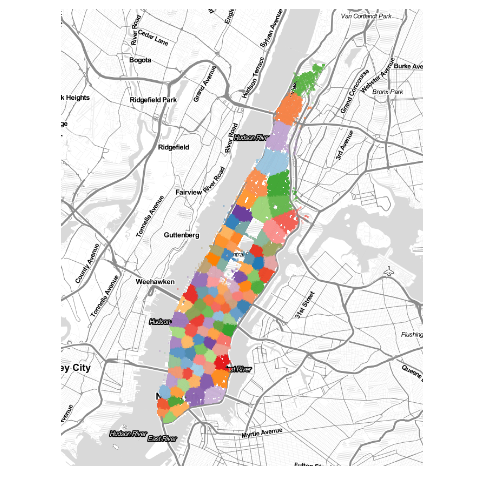

In [9]:
options(repr.plot.width=5, repr.plot.height=5)

box <- c(left = -74.08, bottom = 40.68, right = -73.85, top = 40.9)
map <- get_stamenmap(box, zoom = 12, maptype = "toner-lite")

hm_palette <- colorRampPalette(rev(brewer.pal(10, 'Paired')), space='Lab')  
options(repr.plot.width=4, repr.plot.height=4)

ggmap(map) + 
    geom_point(aes(x = lon, y = lat, color= as.factor(cluster)), data = kmean, alpha = .2, size = .1) +
    scale_color_manual(values=hm_palette(nclusters)) +
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) 

## 1.5 Morning Clusters 8-12h weekdays
In the morning hours (8-12h) during the weekdays, both methods converge that most of the traffic focus on midtown Manhattan.  This area encompasses many tourist attractions and points of interest like time square, the Empire State building, and the Rockefeller Center. In addition to the typical hotspots, K-mean has found an additional hotspot close to the Madison Square Park in Low Midtown Manhattan.

In [124]:
box <- c(left = -74.03, bottom = 40.7, right = -73.93, top = 40.8)
map <- get_stamenmap(box, zoom = 13, maptype = "toner-lite")


grida<- grid

grida <- grida %>% 
     filter(hour >= 8 & hour <= 12, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%   
     mutate(lonUtm500 = lonUtm %/% 500, latUtm400 = latUtm %/% 500)%>%  
     group_by(lonUtm400, latUtm400) %>% 
     mutate(lon400 = mean(lon), lat400 = mean(lat),count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (grida %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

grida <- grida %>%  filter(count >= limit)

In [125]:
kmeana <- kmean

kmeana <- kmeana %>%  
     filter(hour >= 8 & hour <= 12, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%  
     group_by(cluster) %>% 
     mutate(count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (kmeana %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

kmeana <- kmeana %>% filter(count >= limit)

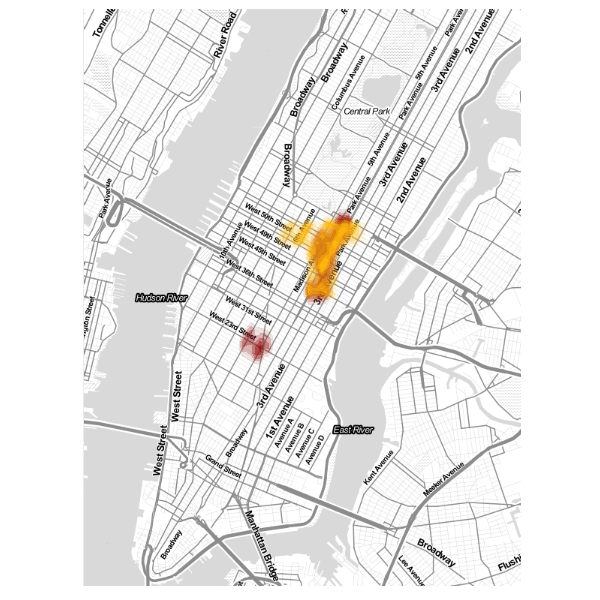

In [127]:
kmeana <- kmeana %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("k-means",nrow(kmeana))) %>%
    mutate_at("set", funs(as.factor))
    
grida <- grida %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("grid",nrow(grida))) %>%
    mutate_at("set", funs(as.factor))
    
d <- rbind(kmeana,grida)

options(repr.plot.width=5, repr.plot.height=5)

p1 <-ggmap(map)+
    stat_density2d(data=d, geom='polygon',bins = 10, aes(x=d$lon,y=d$lat,fill = set, alpha=..level..))+
    scale_fill_manual(values=c("darkred","darkgoldenrod1"))+
    scale_alpha(guide = FALSE)+ 
    xlab(' ')+ylab(' ')+     
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), 
          axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10))  

p1

## 1.6 Afternoon Clusters 13-17h weekdays
In the afternoon (13-17h) during the weekdays, both methods have converged almost 100% on three target areas: 1) Midtown Manhattan close to the Empire State building 2) Midtown Manhattan close to the Grand Central Station and the Rockefeller Center and 3) Carnie Gill close to museum area (Jewish/Guggenheim among others).

In [128]:
grida<- grid

grida <- grida %>% 
     filter(hour >= 13 & hour <= 17, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%   
     mutate(lonUtm500 = lonUtm %/% 500, latUtm400 = latUtm %/% 500)%>%  
     group_by(lonUtm400, latUtm400) %>% 
     mutate(lon400 = mean(lon), lat400 = mean(lat),count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (grida %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

grida <- grida %>%  filter(count >= limit)

In [129]:
kmeana <- kmean

kmeana <- kmeana %>%  
     filter(hour >= 13 & hour <= 17, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%  
     group_by(cluster) %>% 
     mutate(count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (kmeana %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

kmeana <- kmeana %>% filter(count >= limit)

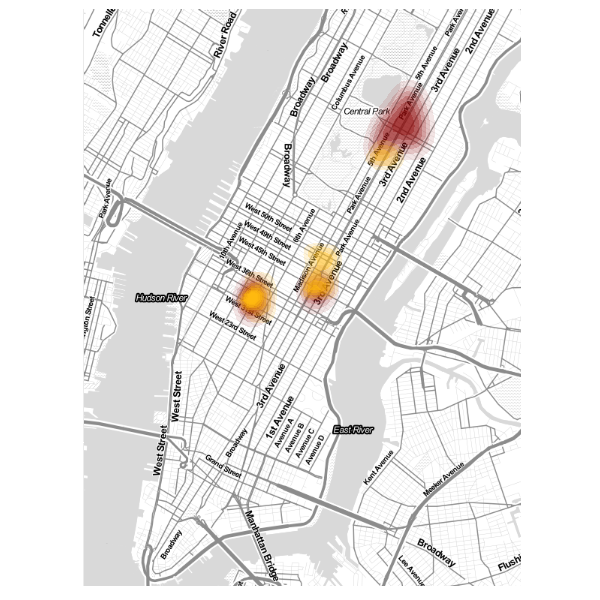

In [130]:
kmeana <- kmeana %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("k-means",nrow(kmeana))) %>%
    mutate_at("set", funs(as.factor))
    
grida <- grida %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("grid",nrow(grida))) %>%
    mutate_at("set", funs(as.factor))
    
d <- rbind(kmeana,grida)

options(repr.plot.width=5, repr.plot.height=5)

p2 <-ggmap(map)+
    stat_density2d(data=d, geom='polygon',bins = 10, aes(x=d$lon,y=d$lat,fill = set, alpha=..level..))+
    scale_fill_manual(values=c("darkred","darkgoldenrod1"))+
    scale_alpha(guide = FALSE)+ 
    xlab(' ')+ylab(' ')+     
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), 
          axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10))  
p2

## 1.7 Evening Clusters 18-21h weekdays
In the evenings (18-21h) during the weekdays, passengers are traveling back to residential areas like the Upper East Side and the East Village. Moreover, there are many trips to Midtown Manhattan where are many leisure activities available in the night.

In [131]:
grida<- grid

grida <- grida %>% 
     filter(hour >= 18 & hour <= 22, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%   
     mutate(lonUtm500 = lonUtm %/% 500, latUtm400 = latUtm %/% 500)%>%  
     group_by(lonUtm400, latUtm400) %>% 
     mutate(lon400 = mean(lon), lat400 = mean(lat),count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (grida %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

grida <- grida %>%  filter(count >= limit)

In [132]:
kmeana <- kmean

kmeana <- kmeana %>%  
     filter(hour >= 18 & hour <= 22, weekday %in% c( "Fri", "Thurs", "Wed", "Tues", "Mon")) %>%  
     group_by(cluster) %>% 
     mutate(count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (kmeana %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

kmeana <- kmeana %>% filter(count >= limit)

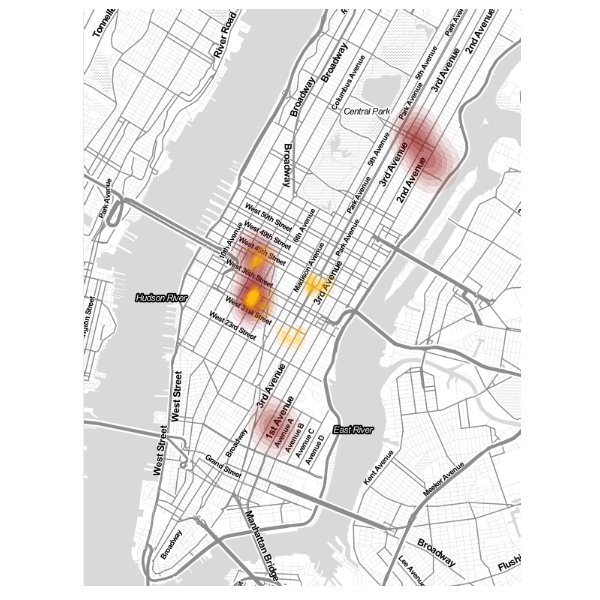

In [133]:
kmeana <- kmeana %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("k-means",nrow(kmeana))) %>%
    mutate_at("set", funs(as.factor))
    
grida <- grida %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("grid",nrow(grida))) %>%
    mutate_at("set", funs(as.factor))
    
d <- rbind(kmeana,grida)

options(repr.plot.width=5, repr.plot.height=5)

p3 <-ggmap(map)+
    stat_density2d(data=d, geom='polygon',bins = 10, aes(x=d$lon,y=d$lat,fill = set, alpha=..level..))+
    scale_fill_manual(values=c("darkred","darkgoldenrod1"))+
    scale_alpha(guide = FALSE)+ 
    xlab(' ')+ylab(' ')+     
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), 
          axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10))  
p3

## 1.8 Late Night Clusters 23-3h weekends
Finally, In the late evenings during the weekend (23-3h), traffic is focused on the Meatpackers district (south-east) and the Greenwich Village (south-west). Both neighborhoods are considered hip destinations by users of Trip Advisor ( (Trip Advisor, 2012)). Additionally, lower Midtown Manhattan is a point of interest as it usually is at other stages of the day.

In [134]:
grida<- grid

grida <- grida %>% 
     filter(hour == 23 | (hour >= 0 & hour <= 3), weekday %in% c( "Sat", "Sun")) %>%   
     mutate(lonUtm500 = lonUtm %/% 500, latUtm400 = latUtm %/% 500)%>%  
     group_by(lonUtm400, latUtm400) %>% 
     mutate(lon400 = mean(lon), lat400 = mean(lat),count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (grida %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

grida <- grida %>%  filter(count >= limit)

In [135]:
kmeana <- kmean

kmeana <- kmeana %>%  
     filter(hour == 23 | (hour >= 0 & hour <= 3), weekday %in% c( "Sat", "Sun")) %>%   
     group_by(cluster) %>% 
     mutate(count = n()) %>% 
     arrange(desc(count)) %>% 
     ungroup()

limit <- (kmeana %>% group_by(count) %>% summarise() %>% arrange(desc(count)))$count[5]

kmeana <- kmeana %>% filter(count >= limit)

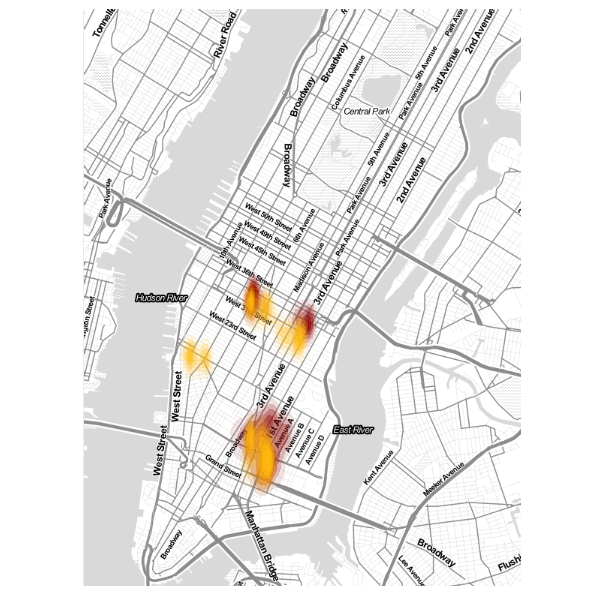

In [137]:
kmeana <- kmeana %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("k-means",nrow(kmeana))) %>%
    mutate_at("set", funs(as.factor))
    
grida <- grida %>%
    dplyr::select(lon,lat) %>%
    mutate( set = rep("grid",nrow(grida))) %>%
    mutate_at("set", funs(as.factor))
    
d <- rbind(kmeana,grida)

options(repr.plot.width=5, repr.plot.height=5)

p4 <-ggmap(map)+
    stat_density2d(data=d, geom='polygon',bins = 10, aes(x=d$lon,y=d$lat,fill = set, alpha=..level..))+
    scale_fill_manual(values=c("darkred","darkgoldenrod1"))+
    scale_alpha(guide = FALSE)+ 
    xlab(' ')+ylab(' ')+     
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), 
          axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10))  
p4

In [18]:
write.table(data, "C:/datasets/NYCtaxi_cluster.csv", sep=",", dec=".", quote=FALSE, row.names=FALSE)